In [8]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker
import copy
import os as os
import logging
from functools import partial
from multiprocessing import Pool

#from scipy.optimize import leastsq # Levenberg-Marquadt Algorithm
from scipy.optimize import curve_fit

In [22]:
# Data file 
sample_path='/data/visitors/nanomax/20190570/2019041008/process/as_deposited_2nd_indent_no_load/'
os.chdir(sample_path)
print(os.getcwd())
#print(os.listdir(sample_path))
extension='.h5'
for file in os.listdir(sample_path):
    if file.endswith(extension):
        print(os.path.join(file))


#sample_file='fit_example3.h5'        
sample_file='scan_0000_pil1m_0000_integ_step.h5'
source=sample_path+sample_file

output_path=sample_path


/data/visitors/nanomax/20190570/2019041008/process/as_deposited_2nd_indent_no_load
fit_example3.h5
fit_example2.h5
._scan_0000_pil1m_0000_integ_step.h5
scan_0000_pil1m_0000_integ_step.h5


In [23]:
# Class definition
class Read1DPilatusData:
    def __init__(self, data_input_file, output_path):
        
        # Store locals
        self.data_input_file = data_input_file
        # set output_path and remove trailing backslash
        self.output_path = os.path.normpath(output_path)
        
         # Separate file path from input file name
        self.filepath_input_file, self.filename = os.path.split(data_input_file)
        
         # Open the file and store number of data entries
        with h5py.File(self.data_input_file, 'r') as hf:
            self.data_keys = list(hf.keys())
            self.total_number_entries = len(self.data_keys)
        # Check that data file exist
        with h5py.File(self.data_input_file, 'r'):
            pass

    def data_read(self):
        
        with h5py.File(self.data_input_file,'r') as h5f:
            q_array = h5f["/entry/integ/q"][()]
            integration_array = h5f["/entry/integ/data"][()]
            sigma_array = h5f["/entry/integ/sigma"][()]
            azimuth_array =h5f[ "/entry/integ/azimuth_range"][()]
        
        return q_array, integration_array, sigma_array,azimuth_array 
    
    
pool = Pool(12)
class Fit1DPilatusData:
    def __init__(self, data_input_file, output_path,q_array,integration_array,sigma_array,azimuth_array):
        
        # Store locals
        self.data_input_file = data_input_file
        # set output_path and remove trailing backslash
        self.output_path = os.path.normpath(output_path)
        
        # Define fit parameters
        self.nbkg_params = 5 # number of bkg parameters
        
        # Create the data set
        #reader = Read1DPilatusData(self.data_input_file, self.output_path)
        #[q_array, integration_array, sigma_array,azimuth_array] = reader.data_read()
        self.q_array=q_array
        self.integration_array = integration_array
        self.sigma_array=sigma_array
        self.azimuth_array=azimuth_array
        
        # Verify the number of chis
        if (np.array_equal(self.q_array.shape[-1],self.integration_array.shape[-1]) and 
            np.array_equal(self.sigma_array.shape[-1],self.integration_array.shape[-1]) and 
            np.array_equal(self.sigma_array.shape[-1],self.azimuth_array.shape[-1])) is True:
            self.nchi= q_array.shape[-1]

    # model functions for diffraction line fitting
    def gaussian(self,x,p):
        y = np.log(2.) * ( (x - p[1])/(0.5*p[2]) )**2
        y = p[0]*np.exp(-y)
        y =  y * 2.*np.sqrt(np.log(2.)/np.pi)/p[2]
        return y

    def lorentzian(self,x,p):
        y = (x - p[1])/(0.5*p[2])
        y = p[0]/(1.+y**2)
        y =  y * 2./np.pi/p[2]
        return y

    # (multi-peak) pseudoVoigth function
    # parameters = [integI, position, fwhm, LorentzianContent]
    # one raw of output matrix per parameters line (one peak in each raw)
    # you can sum them by numpy.sum(pseudoVoigt(x,p),0)
    def pseudoVoigt(self,x,p):
        a = np.array(p)
        m = int(a.size / 4)
        a = a.reshape(m,4)
        y = np.zeros((m,len(x)),dtype=np.float)
        for k in range(0,m):
            if np.absolute(a[k,0])>0.:
                y[k] = (1.-a[k,3])*self.gaussian(x,a[k,0:3])+a[k,3]*self.lorentzian(x,a[k,0:3])
        return y

    
    # model - multiple pseudovoigt with quadratic background
    def model1(self,x,*p):
        y = np.sum(self.pseudoVoigt(x,p[0:-self.nbkg_params]),0)
        y = y + p[-5]/x + p[-4]*x**3 + p[-3]*x**2 + p[-2]*x + p[-1]
        return y

    def full_param_set(self,p,p0,l0):
        l0 = [item for sublist in l0 for item in sublist]
        lindp = np.array(l0)==1 # logical index
        pp = p0.copy()
        pp[lindp] = np.array(p)[()]
        return pp

    def curve_fit_wrap(self,model,x,y,p0,l0,sigma,absolute_sigma,bounds,maxfev,method='trf'):
        def _model(x,*p):
            pp = p0.copy()
            pp[lindp] = np.array(p)[()]
            y = model(x,*pp)
            return y
        l0 = [item for sublist in l0 for item in sublist]
        lindp = np.array(l0)==1 # logical index
        pp = p0[lindp] # eliminate parameters that we do not want to fit
        bounds = (np.asarray(bounds[0])[lindp].tolist(),np.asarray(bounds[1])[lindp].tolist())
        p1, pcov = curve_fit(_model,x,y,pp,sigma=sigma,absolute_sigma=absolute_sigma,bounds=bounds,maxfev=maxfev,method=method)
        return p1, pcov

    def build_bounds(self,p,qpos=np.inf,qrwidth=np.inf):
        p_min = []
        p_max = []
        # peak bounds
        for i in range(p.size-self.nbkg_params):
            pn = i % 4
            if (pn==0):
                # intensity
                p_min = p_min + [0.]
                p_max = p_max + [np.inf]
            elif (pn==1):
                # position
                p_min = p_min + [p[i]-qpos/2]
                p_max = p_max + [p[i]+qpos/2]
            elif (pn==2):
                # width
                p_min = p_min + [0.]
                p_max = p_max + [p[i]*qrwidth]
            elif (pn==3):
                # shape
                p_min = p_min + [0.]
                p_max = p_max + [1.]
            else:
                pass
        # background bounds
        # 1/x
        p_min = p_min + [0.]
        p_max = p_max + [np.inf]
        # polynomial
        for i in range(self.nbkg_params-1):
            p_min = p_min + [-np.inf]
            p_max = p_max + [np.inf]
        return (p_min,p_max)        
    
    # fitting
    def select_good_data(self,x,y):
        lidx = y>0
        #lidx = np.logical_and(lidx, np.logical_and(x>=2.4 , x<=2.8))
        #lidx = np.logical_and(lidx, np.logical_and(x>=4.0 , x<=5.0))
        # first good
        idx1 = np.where(lidx)[0][0]
        # last good
        idx2 = np.where(lidx)[0][-1]
        lidx = np.logical_and(lidx, np.logical_and(x>=x[idx1] , x<=x[idx2]))
        
        return x[lidx],y[lidx]

    def fitting(self,irow,ichi,ps1=False, tialn_ind=[], ps2=True, ps3=True, ps4=True, bkg_ho=True, do_fit=True):
        """ 
        Peak fitting routine
        
        Parameters:
        
        irow: image/frame number
        ichi: number for a chi-range
        ps1: peak set 1, here for TiAlN
        tialn_ind: choose specif TiAlN peaks to knock out
        ps2: peak set 2, here for TiN
        ps3: peak set 3, here for h-AlN
        ps4: peak set 3, here for deep substrate
        bkg_ho: higher order background
        do_fit: execute fitting
        
        Return:
        
        peak_p: Peak parameters
        peak_ep: Errors of peak parameters
        
        Usage: 
        If parameter is set to false: procedure is not executed.
        If parameter is set to true: procedure is executed.
                
        """
        
        
    # execute the fitting process
        #image number given as irow
        #irow=100  
        #azi_index, chi_index given as ichi
        #ichi=0
        
        # get chi range
        chi_range=self.azimuth_array[irow,:,ichi]
        
        # Select data
        xx, yy= self.select_good_data(self.q_array[irow,:,ichi],self.integration_array[irow,:,ichi])
        
        # Select the errors
        # Previous assumption, poissonian noise
        ss = np.sqrt(yy)
        # Using pyFAIs error model 'poisson', see above
        # Currently not implemented, I choose np.sqrt(intensity)
        
        # estimate background
        y0 = np.mean(yy[0:5])
        y1 = np.mean(yy[-5:])
        b1 = (y1-y0)/(xx[-1]-xx[0]) # slope
        b0 = y0 - b1*xx[0] # offset
        # initial parameters
        l0 = [[ 1, 0, 0, 0], # 2.506  1 1 1 0 small   *111  TiAlN     0
              [ 1, 1, 1, 1], # 2.669  1 1 1 0 diffuse  111  TiAlN     1
              [ 1, 1, 1, 1], # 2.669  1 1 1 1 strong   111  TiAlN     2
              [ 1, 1, 1, 1], # 3.076  1 1 1 1 strong   200  TiAlN     3
              [ 1, 0, 0, 0], # 3.345  1 1 1 1 small   *     TiAlN     4
              [ 1, 1, 1, 1], # 4.354  1 1 1 1 strong   220  TiAlN     5
              [ 1, 1, 1, 1], # 5.116  1 1 1 1 strong   311  TiAlN     6
              [ 1, 1, 1, 1], # 5.345  1 1 1 1 strong   222  TiAlN     7
              [ 1, 1, 1, 1], # 2.561  1 1 1 1 strong   111  TiN       8
              [ 1, 1, 1, 1], # 2.957  1 1 1 1 strong   200  TiN       9
              [ 1, 1, 1, 1], # 4.18   1 1 1 1          220  TiN (or a deep sub?) 10
              [ 1, 1, 1, 1], # 4.90   1 1 1 1          331  TiN       11
              [ 1, 1, 1, 1], # 5.915  1 1 1 1          400  TiN       12
              [ 1, 1, 0, 0], # deep sub                               13
              [ 1, 1, 0, 0], # deep sub                               14
              [ 1, 1, 1, 1], #100 h-AlN                               15
              [ 1, 1, 1, 1], #002 h-AlN                               16
              [ 1, 1, 1, 1], #101 h-AlN                               17
              [ 1, 1, 1, 1], #102 h-AlN                               18
              [ 1, 1, 1, 1], #110 h-AlN                               19
              [ 1, 1, 1, 1], #103 h-AlN                               20
              [ 1,1,1,1,1]] # backgrounfrom multiprocessing import Pool

#def f(x):
#    return x*x

#if __name__ == '__main__':
#    p = Pool(5)
#    print(p.map(f, [1, 2, 3]))

        deep_sub_ind = [13,14]
        tin_ind = [8,9,10,11,12]
        aln_ind = [15,16,17,18,19,20]

        p0 = [[0.2, 2.506, 0.02, 0.0], # small *111
              [5.1, 2.669, 0.7, 1.0],   # diffuse 111
              [5.1, 2.669, 0.014, 0.3], # strong 111
              [4.3, 3.076, 0.030, 0.8], # strong 200
              [0.1, 3.345, 0.017, 0.0], # small *
              [1.8, 4.363, 0.035, 0.4], # strong 220
              [0.6, 5.116, 0.040, 0.4], # strong 311
              [0.5, 5.345, 0.040, 0.4], # strong 222
              [2.161, 2.561, 0.01769, 0.183], # strong 111 TiN
              [5.4896, 2.957, 0.029269, 0.740], # strong 200 TiN
              [1.0, 4.18, 0.029269, 0.740], # TiN 220
              [1.0, 4.90, 0.029269, 0.740], # TiN 311
              [2.0, 5.915, 0.029269, 0.740], # TiN 400
              [1.0, 1.000, 0.029269, 0.740], # deep sub
              [1.0, 1.7, 0.029269, 0.740], # deep sub
              [1.0, 2.32982621, 0.029269, 0.740], #100 h-AlN 
              [1.0, 2.52377231, 0.029269, 0.740], #002 h-AlN
              [1.0, 2.65344147, 0.029269, 0.740], #101 h-AlN
              [1.0, 3.43488723, 0.029269, 0.740], #102 h-AlN
              [1.0, 4.02576767, 0.029269, 0.740], #110 h-AlN
              [1.0, 4.44466219, 0.029269, 0.740], #103 h-AlN
             ] 
        #Potential peaks:
        #	peak	Q
        #WC	001	2.213469672
        #	100	2.494987346
        #	101	3.335023986#
        #	110	4.322084816
        #	002	4.427578259
        #	111	4.855742347
        #		
        #Co	111	3.061531074
        #	200	3.531690495
        #	220	5.002511151
        
        
        #h-AlN hkl Q (A-1)
        #      100 2.32982621
        #      002 2.52377231
        #      101 2.65344147
        #      102 3.43488723
        #      110 4.02576767
        #      103 4.44466219

        
        # Number of peaks (no background)
        npeaks = np.array(p0).shape[0]
        
        # set zero intensity and fix some TiAlN peaks
        #tialn_ind=[2]
        #tialn_ind=[7]
        #tialn_ind=[4]
        #tialn_ind=[2]
        #if (True):
        if ps1:
            print('\033[35mWarning! Some TiAlN peaks are fixed.\033[0m')
            for i in tialn_ind:
                for k in range(4):
                    l0[i][k] = 0 # fix
                    p0[i][0] = 0 # set zero intensity
       
        # set zero intensity and fix tin peaks
        #if(True):
        if ps2:
            print('\033[35m Warning! Some TiN peaks are fixed.\033[0m')
            for i in tin_ind:
                for k in range(4):
                    l0[i][k] = 0 # fix
                    p0[i][0] = 0 # set zero intensity
        
        # set zero intensity and fix h-AlN peaks
        #if(True):
        if ps3:
            print('\033[35m Warning! Some h-Aln peaks are fixed.\033[0m')
            for i in aln_ind:
                for k in range(4):
                    l0[i][k] = 0 # fix
                    p0[i][0] = 0 # set zero intensity
        
        
        # set zero intensity and fix deep-sub peaks
        #if(True):
        if ps4:
            print('\033[34m Warning! Deep substrate peaks are fixed.\033[0m')
            for i in deep_sub_ind:
                for k in range(4):
                    l0[i][k] = 0 # fix
                    p0[i][0] = 0 # set zero intensity           
                    

        # fix all peaks (do not use !) (False = disabled)
        if(False):
            print('\033[35m Warning! Peaks are all fixed.\033[0m')
            for k in range(npeaks):
                l0[k][1] = 0 # position
                l0[k][2] = 0 # width
                l0[k][3] = 0 # shape

        p0 = np.concatenate((np.array(p0).reshape(npeaks*4),[0.0,0.0,0.0,b1,b0]))
        perr = copy.deepcopy(p0)*0
        p1 = copy.deepcopy(p0)*0
        bounds = self.build_bounds(p0,qpos=0.05,qrwidth=2.0)
        
        # fitting
        #if (True):
        if do_fit:
            # --- the 1st fit stage ---
            _l0 = copy.deepcopy(l0)
            
            # fix higher order bkg coeff
            # Can be switched off and on now
            #if (True):
            if bkg_ho:
                if bkg_ho is False:
                    print('Warning! Some TiAlN peaks are fixed.')
                    
                _l0[-1][-(self.nbkg_params-1):-2] = [0]*(self.nbkg_params-3)

            # fix all peak width and shape parameter and all positions
            for k in range(npeaks):
                _l0[k][1] = 0 # position
                _l0[k][2] = 0 # width
                _l0[k][3] = 0 # shape
            p1, pcov = self.curve_fit_wrap(self.model1,xx,yy,p0,_l0,sigma=ss,absolute_sigma=True,bounds=bounds,maxfev=100,method='trf')
            # return non-fitted parameters
            p0 = self.full_param_set(p1,p0,_l0)
            # --- the 2nd fit stage ---
            _l0 = copy.deepcopy(l0)
            # fix all peak width and shape parameter and all positions
            for k in range(npeaks):
                _l0[k][1] = 0 # position
                _l0[k][2] = 0 # width
                _l0[k][3] = 0 # shape
            p1, pcov = self.curve_fit_wrap(self.model1,xx,yy,p0,_l0,sigma=ss,absolute_sigma=True,bounds=bounds,maxfev=100,method='trf')
            # return non-fitted parameters
            p0 = self.full_param_set(p1,p0,_l0)
            # --- the 3rd fit stage ---
            _l0 = copy.deepcopy(l0)
            _p0 = copy.deepcopy(p0)
            # fix all peak parameters, outside of range
            for k in range(npeaks):
                if ((_p0[k*4+1]>=xx[-1]) or (_p0[k*4+1]<=xx[0])):
                    _l0[k][0] = 0 # intensity
                    _l0[k][1] = 0 # position
                    _l0[k][2] = 0 # width
                    _l0[k][3] = 0 # shape
                    _p0[k*4+0] = 0 # set intensity to zero
            # fix all peak width and shape parameter and all positions
            for k in range(npeaks):
                _l0[k][3] = 0 # shape
            p1, pcov = self.curve_fit_wrap(self.model1,xx,yy,_p0,_l0,sigma=ss,absolute_sigma=True,bounds=bounds,maxfev=100,method='trf')
            # return non-fitted parameters
            p0 = self.full_param_set(p1,_p0,_l0)
            # --- the 4th fit stage ---
            _l0 = copy.deepcopy(l0)
            _p0 = copy.deepcopy(p0)
            # fix all peak parameters, outside of range
            for k in range(npeaks):
                if ((_p0[k*4+1]>=xx[-1]) or (_p0[k*4+1]<=xx[0])):
                    _l0[k][0] = 0 # intensity
                    _l0[k][1] = 0 # position
                    _l0[k][2] = 0 # width
                    _l0[k][3] = 0 # shape
                    _p0[k*4+0] = 0 # set intensity to zero
            p1, pcov = self.curve_fit_wrap(self.model1,xx,yy,_p0,_l0,sigma=ss,absolute_sigma=True,bounds=bounds,maxfev=500,method='trf')
            perr = np.sqrt(np.diag(pcov))
            # return non-fitted parameters
            p1 = self.full_param_set(p1,_p0,_l0)
            perr = self.full_param_set(perr,np.zeros(p1.shape),_l0)
            yyc = self.model1(xx,*p1)
        else:
            # not fitting
            p1 = copy.deepcopy(p0)
            yyc = self.model1(xx,*p0)
        
        print('\n nchi %d, chi_range (%.1f %.1f)' %(ichi, chi_range[0], chi_range[1]))
        print( np.array(p1[:-self.nbkg_params]).reshape(npeaks,4) )
        print( p1[-self.nbkg_params:] )

        peak_p = np.array(p1[:-self.nbkg_params]).reshape(npeaks,4)
        peak_ep = np.array(perr[:-self.nbkg_params]).reshape(npeaks,4) 
        
        # plot datafrom multiprocessing import Pool

#def f(x):
#    return x*x

#if __name__ == '__main__':
  #  p = Pool(5)
  #  print(p.map(f, [1, 2, 3]))
        font1=12
        locator_value=0.5

        plt.figure(figsize=(16, 4))
        ax1=plt.subplot(121)
        plt.plot(xx,yy,"*")
        plt.plot(xx,yyc,"-")
        plt.plot(xx,yyc-yy,"g-")
        plt.title('Fit, frame: %d, azimuthal range (%.1f$\degree$, %.1fd$\degree$), $\chi_{center}=$%.1f$\degree$, ichi=%d' 
                  %(irow, chi_range[0], chi_range[1], (chi_range[1]-chi_range[0])/2+chi_range[0],ichi),fontdict={'fontsize': font1}) 
        plt.xlabel('q $[\AA^{-1}]$',fontdict={'fontsize':font1})
        plt.ylabel('Intensity',fontdict={'fontsize':font1})
        plt.grid(which='both',axis='both')
        loc = plticker.MultipleLocator(base=locator_value) # this locator puts ticks at regular intervals
        ax1.xaxis.set_major_locator(loc)

        ax2=plt.subplot(122)
        plt.semilogy(xx,yy,"*")
        plt.semilogy(xx,yyc,"-")

        for i in range(0,npeaks):
            plt.axvline(x=peak_p[i][1],color='midnightblue',alpha=0.3)

        plt.title('Fit, frame: %d, azimuthal range (%.1f$\degree$, %.1fd$\degree$), $\chi_{center}=$%.1f$\degree$, ichi=%d"' 
                  %(irow, chi_range[0], chi_range[1], (chi_range[1]-chi_range[0])/2+chi_range[0],ichi),fontdict={'fontsize': font1}) 
        plt.xlabel('q $[\AA^{-1}]$',fontdict={'fontsize':font1})
        plt.ylabel('log(Intensity)',fontdict={'fontsize':font1})
        #plt.grid(which='both',axis='both')
        loc = plticker.MultipleLocator(base=locator_value) # this locator puts ticks at regular intervals
        ax2.xaxis.set_major_locator(loc)
        #plt.show()

        # The fitting function returns the parameter-matrix and its error-matrix.
        return peak_p, peak_ep, npeaks

    def fitting_functions(self):
        fittings = (
            partial(self.fitting, ps1=False, tialn_ind=[],  ps2=True, ps3=True, ps4=True,  bkg_ho=True,  do_fit=True),  
            partial(self.fitting, ps1=False, tialn_ind=[],  ps2=False,  ps3=True, ps4=True,  bkg_ho=True,  do_fit=True),
            partial(self.fitting, ps1=True,  tialn_ind=[],  ps2=False, ps3=True, ps4=True,  bkg_ho=True,  do_fit=True),
            partial(self.fitting, ps1=True,  tialn_ind=[2], ps2=True,  ps3=True, ps4=True,  bkg_ho=True,  do_fit=True),
            partial(self.fitting, ps1=True,  tialn_ind=[4], ps2=True,  ps3=True, ps4=True,  bkg_ho=True,  do_fit=True),
            partial(self.fitting, ps1=True,  tialn_ind=[7], ps2=True,  ps3=True, ps4=True,  bkg_ho=True,  do_fit=True),
            partial(self.fitting, ps1=False,  tialn_ind=[],  ps2=True, ps3=False, ps4=True,  bkg_ho=True,  do_fit=True),
            partial(self.fitting, ps1=False, tialn_ind=[],  ps2=False, ps3=True, ps4=True,  bkg_ho=False, do_fit=True),
            partial(self.fitting, ps1=False, tialn_ind=[],  ps2=True,  ps3=True, ps4=False, bkg_ho=True,  do_fit=True),

        )

        for fit in fittings:
            yield fit


    def get_irows(self, x_start, x_end, y_start, y_end,  x_len):
        output = []
        for i in range(y_start, y_end):
            y_offset = x_len * i
            for j in range(x_start + y_offset, x_end + y_offset):
                output.append(j)
        return output

    def multi_fitting(self, irows, chi_index):
           
        # Save the result, preparation
        nchi = self.nchi
        nimg = len(irows)
        
        # call once the fitting func to get npeaks, no fitting
        
        print(" Dummy output")
        dummy_result=self.fitting(irows[0], chi_index[0], ps1=False, tialn_ind=[],  ps2=True, ps3=True, ps4=True,  bkg_ho=True,  do_fit=False)
        # npeaks
        npeaks=dummy_result[2]
        
        print('\n')
        
        
        # Allocate the storage matrix
        dset_p = np.zeros((nchi,nimg,npeaks,4),dtype=np.float)
        dset_p_ep = np.zeros((nchi,nimg,npeaks,4),dtype=np.float)
        print(dset_p.shape)
        print(dset_p_ep.shape)
        self._iter_irow(chi_index, npeaks, dset_p, dset_p_ep)
        print("#######################################")
        print(dset_p)
        print("#######################################")
        
    
    def _try_fittings(self, irow,  ichi, npeaks):
        """ Per"""
        for fit_func in self.fitting_functions():
            print("\nTrying fitting with : ", irow, ichi, fit_func)
            try:
                result = fit_func(irow, ichi)
                print("\033[92m----> Succeed to fit with: ", fit_func,  "\033[0m")
                return result , ichi
            except RuntimeError as e:
                print("\033[93m----> Fail to fit with: ", irow, ichi, e,"\n",fit_func, "\033[0m")
        return (([[np.nan, np.nan , np.nan, np.nan]]*npeaks, [[np.nan, np.nan , np.nan, np.nan]]*npeaks, npeaks)), ichi # TODO fix it


    def _iter_ichi(self, irow, irow_index, chi_index, npeaks, p_array, p_ep_array):
        for ichi in chi_index:
            print("\n#############\nICHI", ichi)
            p, p_ep, peaks = self._try_fittings(irow, ichi, npeaks)
            p_array[ichi][irow_index] = p 
            p_ep_array[ichi][irow_index] = p_ep
    
    def _iter_ichi_multi(self, irow, irow_index, chi_index, npeaks, p_array, p_ep_array):
        f = partial(self._iter_ichi, irow=irow, npeaks=npeaks)
        output = pool.map(f, chi_index)
        for result, ichi in output:
            p, p_ep, peaks = result
            p_array[ichi][irow_index] = p 
            p_ep_array[ichi][irow_index] = p_ep
    
            
    def _iter_irow(self, chi_index, nbpeaks, p_array, p_ep_array):
        for irow_index, irow in enumerate(irows):        
            print("\033[95m++++++++++++++++"*3)
            print('IROW', irow, "\033[0m")
            self._iter_ichi(irow, irow_index, chi_index, nbpeaks, p_array, p_ep_array)
            
    
    
            
            
                

class PeakPositions_TiAlN:
    def __init__(self, hkl_l=None, apar=None):
        
        if hkl_l is None:
            hkl_l = [[1,1,1],[2,0,0],[2,2,0],[3,1,1],[2,2,2],[4,0,0]]
            Qhkl = np.zeros((len(hkl_l),))
        if apar is None:
            apar = 4.09 # (A)
        for k in range(len(hkl_l)):
            hkl = np.asarray(hkl_l[k])
            Qhkl[k] = 2*np.pi/apar*np.sqrt(np.dot(hkl,hkl))
            print("TiAlN %d %d %d    %f" % (hkl[0],hkl[1],hkl[2],Qhkl[k]))
    
        
class PeakPositions_TiN:
    def __init__(self, hkl_l=None,apar=None):
        
        if hkl_l is None:
            hkl_l = [[1,1,1],[2,0,0],[2,2,0],[3,1,1],[2,2,2],[4,0,0]]
            Qhkl = np.zeros((len(hkl_l),))
        if apar is None:
            apar = 4.249 # (A) #Wikipedia   #Magnus: 4.2
        for k in range(len(hkl_l)):
            hkl = np.asarray(hkl_l[k])
            Qhkl[k] = 2*np.pi/apar*np.sqrt(np.dot(hkl,hkl))
            print("TiN %d %d %d    %f" % (hkl[0],hkl[1],hkl[2],Qhkl[k]))
            
class PeakPositions_Co:  
      def __init__(self, hkl_l=None,apar=None):
        
        if hkl_l is None:
            hkl_l = [[1,1,1],[2,0,0],[2,2,0],[3,1,1]]
            Qhkl = np.zeros((len(hkl_l),))
        if apar is None:
            apar = 3.548 # (A) #Wikipedia   #Magnus: 4.2
        for k in range(len(hkl_l)):
            hkl = np.asarray(hkl_l[k])
            Qhkl[k] = 2*np.pi/apar*np.sqrt(np.dot(hkl,hkl))
            print("Co %d %d %d    %f" % (hkl[0],hkl[1],hkl[2],Qhkl[k]))
            
            
            
if __name__ == '__main__':
    PeakPositions_TiAlN()      
    PeakPositions_TiN()
    PeakPositions_Co()
    

TiAlN 1 1 1    2.660830
TiAlN 2 0 0    3.072462
TiAlN 2 2 0    4.345118
TiAlN 3 1 1    5.095102
TiAlN 2 2 2    5.321661
TiAlN 4 0 0    6.144925
TiN 1 1 1    2.561261
TiN 2 0 0    2.957489
TiN 2 2 0    4.182521
TiN 3 1 1    4.904441
TiN 2 2 2    5.122521
TiN 4 0 0    5.914978
Co 1 1 1    3.067304
Co 2 0 0    3.541818
Co 2 2 0    5.008887
Co 3 1 1    5.873441


In [24]:
file1=Read1DPilatusData(source,output_path)
q_array,integration_array,sigma_array,azimuth_array=file1.data_read()

#print(q_array.shape)
#print(integration_array.shape)
#print(sigma_array.shape)
#print(azimuth_array.shape)

In [ ]:
fit1=Fit1DPilatusData(source,output_path,q_array,integration_array,sigma_array,azimuth_array)

     
#chi_index=[0]
#irows=get_irows(35,37,34,37,71)
#irows=[3400, 4, 8, 4389, 4978, 4980]


#chi_ind=[0, 1 , 3, 8]
chi_ind=[0]
irows=[0]

fit1.multi_fitting(irows, chi_ind)

        


 Dummy output
 Warning! Some TiN peaks are fixed.
 Warning! Some h-Aln peaks are fixed.
 Warning! Deep substrate peaks are fixed.

 nchi 0, chi_range (-7.5 7.5)
[[0.2        2.506      0.02       0.        ]
 [5.1        2.669      0.7        1.        ]
 [5.1        2.669      0.014      0.3       ]
 [4.3        3.076      0.03       0.8       ]
 [0.1        3.345      0.017      0.        ]
 [1.8        4.363      0.035      0.4       ]
 [0.6        5.116      0.04       0.4       ]
 [0.5        5.345      0.04       0.4       ]
 [0.         2.561      0.01769    0.183     ]
 [0.         2.957      0.029269   0.74      ]
 [0.         4.18       0.029269   0.74      ]
 [0.         4.9        0.029269   0.74      ]
 [0.         5.915      0.029269   0.74      ]
 [0.         1.         0.029269   0.74      ]
 [0.         1.7        0.029269   0.74      ]
 [0.         2.32982621 0.029269   0.74      ]
 [0.         2.52377231 0.029269   0.74      ]
 [0.         2.65344147 0.029269   0.74 

In [ ]:



#fit1.fitting(1500,nchi)
#fit1.fitting(1500,0) #I am missing a peak here, what it is?
#fit1.fitting(3000,1)
#fit1.fitting(3000,0)  #Here I need to switch of the TiN
#fit1.fitting(3000,1)
#fit1.fitting(3000,2)
#fit1.fitting(3000,3)
#fit1.fitting(3000,4)
#fit1.fitting(3000,5)
#fit1.fitting(3000,6)
#fit1.fitting(3000,8)
#fit1.fitting(3600,0)   #Here I need to switch of the TiN 
#fit1.fitting(3600,1)
#fit1.fitting(3600,2)
#fit1.fitting(3600,3)
#fit1.fitting(3600,4)
#fit1.fitting(3600,5)
#fit1.fitting(3600,6)
#fit1.fitting(3600,8)   #Here I need to switch of TiN, some TiAlN tialn_index=[4], and I need to increase the intensity for 200 TiAlN to 50

#fit1.fitting(2535,0)    #I switched here TiN off
#fit1.fitting(2535,1)
#fit1.fitting(2535,2)
#fit1.fitting(2535,3)    #TiN off 
#fit1.fitting(2535,4)
#fit1.fitting(2535,5)     #TiN off and  switched off tialn_index=[2]  111  TiAlN 
#fit1.fitting(2535,6)
#fit1.fitting(2535,8)

#fit1.fitting(1606,1)   # TiN off, all good
#fit1.fitting(1606,2)
#fit1.fitting(1606,3)
#fit1.fitting(1606,4)
#fit1.fitting(1606,5)
#fit1.fitting(1606,6)
#fit1.fitting(1606,8)
#fit1.fitting(1606,0)

#fit1.fitting(3831,0)  #Air, how to handle this?
#fit1.fitting(3831,1)
#fit1.fitting(3831,2)
#fit1.fitting(3831,3)
#fit1.fitting(3831,4)
#fit1.fitting(3831,5)
#fit1.fitting(3831,6)
#fit1.fitting(3831,8)


#fit1.fitting(2520,0) 
#fit1.fitting(2520,1)
#fit1.fitting(2520,2)
#fit1.fitting(2520,3)
#fit1.fitting(2520,4)
#fit1.fitting(2520,5)
#fit1.fitting(2520,6)
#fit1.fitting(2520,8)   #TiN off andf  tialn_index=[7] off!


#fit1.fitting(2823,0)    #TiN off and all good
#fit1.fitting(2823,1) 
#fit1.fitting(2823,2) 
#fit1.fitting(2823,3) 
#fit1.fitting(2823,4) 
#fit1.fitting(2823,5) 
#fit1.fitting(2823,6) 
#fit1.fitting(2823,8) 


#fit1.fitting(6,0)    #TiN on and TiAlN on
#fit1.fitting(6,1) 
#fit1.fitting(6,2)     #TiN on, TiAl on, but bkg not fixed!
#fit1.fitting(6,3) 
#fit1.fitting(6,4) 
#fit1.fitting(6,5) 
#fit1.fitting(6,6) 
#fit1.fitting(6,8) 

#irow=77
#fit1.fitting(irow,0)    
#fit1.fitting(irow,1) 
#fit1.fitting(irow,2)   #TiN on, TiAl on, but bkg not fixed!     
#fit1.fitting(irow,3) 
#fit1.fitting(irow,4) 
#fit1.fitting(irow,5) 
#fit1.fitting(irow,6) 
#fit1.fitting(irow,8) 


irow=2*77
#fit1.fitting(irow,0)    #TiN, TiAlN on
#fit1.fitting(irow,1) 
#fit1.fitting(irow,2)      ##TiN on, TiAl on, but bkg not fixed! Then it works    
#fit1.fitting(irow,3)       #TiN fixed=off
#fit1.fitting(irow,4) 
#fit1.fitting(irow,5)        ##TiN fixed=off
#fit1.fitting(irow,6) 
#fit1.fitting(irow,8) 


#irow=6*77
#fit1.fitting(irow,0)   
#fit1.fitting(irow,1) 
#fit1.fitting(irow,2)      #Guess Background     
#fit1.fitting(irow,3)      #TiN off? maybe guess
#fit1.fitting(irow,4) 
#fit1.fitting(irow,5) 
#fit1.fitting(irow,6) 
#fit1.fitting(irow,8) 

index=[5,10,15,20,30,35,40,50]
#index=[20]
offset=40


#for i in index:
    #irow=i*71+offset
    #print(irow)
    #fit1.fitting(irow,0)    
#    fit1.fitting(irow,1) 
    #fit1.fitting(irow,2)    
    #fit1.fitting(irow,3) 
    #fit1.fitting(irow,4) 
    #fit1.fitting(irow,5) 
    #fit1.fitting(irow,6) 
    #fit1.fitting(irow,8) 





In [ ]:
#mesh sx -16.5 -9.5 70 sy -3.5 3.5 70 1
np.shape(q_array)

In [ ]:
2823 % 71

In [ ]:
39*71+54

In [ ]:
print("\033[92mHello\033[0mWorld")

In [ ]:
def get_irows(x_start, x_end, y_start, y_end,  x_len):
    output = []
    for i in range(y_start, y_end):
        y_offset = x_len * i
        for j in range(x_start + y_offset, x_end + y_offset):
            output.append(j)
    return output
        
        
        

In [ ]:
#def get_irows(x_start, x_end, y_start, y_end,  x_len):
#    for i in range(y_start, y_end):
#        y_offset = x_len * i
#        yield range(x_start + y_offset, x_end + y_offset)
    

In [183]:
def fun(a,b,c):
    return a,b,c

test=fun(1,2,3)
print(test[2])

3


In [198]:
a=get_irows(20,30,40,50,71)
print(a)
a[0]

[2860, 2861, 2862, 2863, 2864, 2865, 2866, 2867, 2868, 2869, 2931, 2932, 2933, 2934, 2935, 2936, 2937, 2938, 2939, 2940, 3002, 3003, 3004, 3005, 3006, 3007, 3008, 3009, 3010, 3011, 3073, 3074, 3075, 3076, 3077, 3078, 3079, 3080, 3081, 3082, 3144, 3145, 3146, 3147, 3148, 3149, 3150, 3151, 3152, 3153, 3215, 3216, 3217, 3218, 3219, 3220, 3221, 3222, 3223, 3224, 3286, 3287, 3288, 3289, 3290, 3291, 3292, 3293, 3294, 3295, 3357, 3358, 3359, 3360, 3361, 3362, 3363, 3364, 3365, 3366, 3428, 3429, 3430, 3431, 3432, 3433, 3434, 3435, 3436, 3437, 3499, 3500, 3501, 3502, 3503, 3504, 3505, 3506, 3507, 3508]


2860

In [97]:
p0 = [[0.2, 2.506, 0.02, 0.0], # small *111
              [5.1, 2.669, 0.7, 1.0],   # diffuse 111
              [5.1, 2.669, 0.014, 0.3], # strong 111
              [4.3, 3.076, 0.030, 0.8], # strong 200
              [0.1, 3.345, 0.017, 0.0], # small *
              [1.8, 4.363, 0.035, 0.4], # strong 220
              [0.6, 5.116, 0.040, 0.4], # strong 311
              [0.5, 5.345, 0.040, 0.4], # strong 222
              [2.161, 2.561, 0.01769, 0.183], # strong 111 TiN
              [5.4896, 2.957, 0.029269, 0.740], # strong 200 TiN
              [1.0, 4.18, 0.029269, 0.740], # deep sub? TiN 220
              [1.0, 4.90, 0.029269, 0.740], # TiN 311
              [2.0, 5.915, 0.029269, 0.740], # TiN 400
              [1.0, 1.000, 0.029269, 0.740], # deep sub
              [1.0, 1.7, 0.029269, 0.740], # deep sub
              ] 

(15, 4)
[[0.2, 2.506, 0.02, 0.0], [5.1, 2.669, 0.7, 1.0], [5.1, 2.669, 0.014, 0.3], [4.3, 3.076, 0.03, 0.8], [0.1, 3.345, 0.017, 0.0], [1.8, 4.363, 0.035, 0.4], [0.6, 5.116, 0.04, 0.4], [0.5, 5.345, 0.04, 0.4], [2.161, 2.561, 0.01769, 0.183], [5.4896, 2.957, 0.029269, 0.74], [1.0, 4.18, 0.029269, 0.74], [1.0, 4.9, 0.029269, 0.74], [2.0, 5.915, 0.029269, 0.74], [1.0, 1.0, 0.029269, 0.74], [1.0, 1.7, 0.029269, 0.74]]


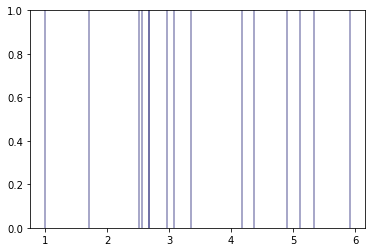

(60,)
